# Preprocessing pipeline

In [118]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
from scipy.signal import find_peaks, savgol_filter
import seaborn as sns
import os
import random
import cv2
import matplotlib.patches as patches
import re

In [119]:
# Set random seed
random.seed(41)

# Set max pixels
Image.MAX_IMAGE_PIXELS = None

In [120]:
# Seaborn style
sns.set()
sns.set_theme(style="darkgrid")
coolwarm = sns.color_palette("coolwarm")
pastel = sns.color_palette("pastel")

In [121]:
BASE_PATH = '/kaggle/input/UBC-OCEAN'
TRAIN_IMG_PATH = BASE_PATH + "/train_images"
TRAIN_THUMB_PATH = BASE_PATH + "/train_thumbnails"
TRAIN_ANN_PATH = BASE_PATH + "/train.csv"
TEST_IMG_PATH = BASE_PATH + "/test_thumbnails"
TEST_ANN_PATH = BASE_PATH + "/test.csv"

## Original images

In [122]:
# Train annotations overview
train_df = pd.read_csv(TRAIN_ANN_PATH)
train_df.head(8)

,image_id,label,image_width,image_height,is_tma
0,4,HGSC,23785,20008,False
1,66,LGSC,48871,48195,False
2,91,HGSC,3388,3388,True
3,281,LGSC,42309,15545,False
4,286,EC,37204,30020,False
5,431,HGSC,39991,40943,False
6,706,HGSC,75606,25965,False
7,970,HGSC,32131,18935,False


In [123]:
# Create a dictionary with random samples
random_samples = {}

# List of unique labels in the DataFrame
unique_labels = train_df['label'].unique()

# Randomly select one image for each label where is_tma=True
# and one image where is_tma=False
for label in unique_labels:
    is_tma_true_sample = train_df[(train_df['label'] == label) & (train_df['is_tma'] == True)]
    is_tma_false_sample = train_df[(train_df['label'] == label) & (train_df['is_tma'] == False)]
    
    random_sample = random.choice(is_tma_true_sample['image_id'].tolist())
    random_samples[random_sample] = {'label': label, 'is_tma': True}
    
    random_sample = random.choice(is_tma_false_sample['image_id'].tolist())
    random_samples[random_sample] = {'label': label, 'is_tma': False}

# Display the resulting dictionary
print(random_samples)

{50932: {'label': 'HGSC', 'is_tma': True}, 25792: {'label': 'HGSC', 'is_tma': False}, 29084: {'label': 'LGSC', 'is_tma': True}, 10252: {'label': 'LGSC', 'is_tma': False}, 48734: {'label': 'EC', 'is_tma': True}, 44232: {'label': 'EC', 'is_tma': False}, 42857: {'label': 'CC', 'is_tma': True}, 48506: {'label': 'CC', 'is_tma': False}, 21020: {'label': 'MC', 'is_tma': True}, 39252: {'label': 'MC', 'is_tma': False}}


In [124]:
random_samples = sorted(random_samples.items(), key=lambda x: not x[1]['is_tma'])
random_samples = dict(random_samples)
print(random_samples)

{50932: {'label': 'HGSC', 'is_tma': True}, 29084: {'label': 'LGSC', 'is_tma': True}, 48734: {'label': 'EC', 'is_tma': True}, 42857: {'label': 'CC', 'is_tma': True}, 21020: {'label': 'MC', 'is_tma': True}, 25792: {'label': 'HGSC', 'is_tma': False}, 10252: {'label': 'LGSC', 'is_tma': False}, 44232: {'label': 'EC', 'is_tma': False}, 48506: {'label': 'CC', 'is_tma': False}, 39252: {'label': 'MC', 'is_tma': False}}


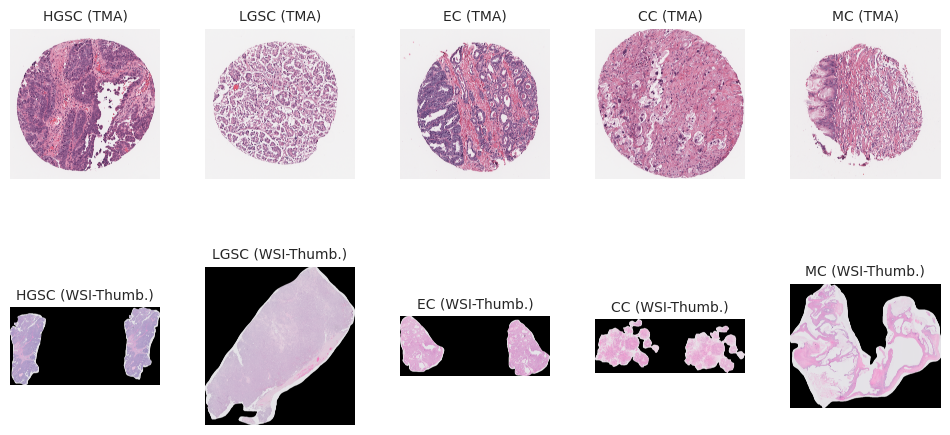

In [125]:
# Define the labels
labels = train_df["label"].unique()

# Create a figure with two rows and five columns
fig, axes = plt.subplots(2, 5, figsize=(12, 6))

# Iterate through the labels and populate the figure
for col, label in enumerate(labels):
    # Find the corresponding image with is_tma=True
    tma_true_image_id = [k for k, v in random_samples.items() if v['label'] == label and v['is_tma'] is True][0]
    tma_true_image_path = f"{TRAIN_IMG_PATH}/{tma_true_image_id}.png"
    
    # Find the corresponding image with is_tma=False THUMB
    tma_false_image_id = [k for k, v in random_samples.items() if v['label'] == label and v['is_tma'] is False][0]
    tma_false_image_path = f"{TRAIN_THUMB_PATH}/{tma_false_image_id}_thumbnail.png"
    
    # Load and display the images
    tma_true_image = Image.open(tma_true_image_path)
    tma_false_image = Image.open(tma_false_image_path)
    
    axes[0, col].imshow(tma_true_image)
    axes[0, col].set_title(f"{label} (TMA)", fontsize=10)
    axes[0, col].axis('off')

    axes[1, col].imshow(tma_false_image)
    axes[1, col].set_title(f"{label} (WSI-Thumb.)", fontsize=10)
    axes[1, col].axis('off')

# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0.3, hspace=0.1)

# Show the figure
plt.show()

## Resize to 2048x2048 px

In [126]:
# Get image ids and paths
image_ids = [k for k, v in random_samples.items()]
print(image_ids)
image_id_paths = [f"{TRAIN_IMG_PATH}/{img}.png" for img in image_ids]
print(image_id_paths)

[50932, 29084, 48734, 42857, 21020, 25792, 10252, 44232, 48506, 39252]
['/kaggle/input/UBC-OCEAN/train_images/50932.png', '/kaggle/input/UBC-OCEAN/train_images/29084.png', '/kaggle/input/UBC-OCEAN/train_images/48734.png', '/kaggle/input/UBC-OCEAN/train_images/42857.png', '/kaggle/input/UBC-OCEAN/train_images/21020.png', '/kaggle/input/UBC-OCEAN/train_images/25792.png', '/kaggle/input/UBC-OCEAN/train_images/10252.png', '/kaggle/input/UBC-OCEAN/train_images/44232.png', '/kaggle/input/UBC-OCEAN/train_images/48506.png', '/kaggle/input/UBC-OCEAN/train_images/39252.png']


In [127]:
# Get the size of the imagea and aspect ratios
resized_images = {}

def resize_imgs(img, new_height=2048):
    
    img = Image.open(img)
    width, height = img.size
    aspect_ratio = width / height
    new_width = int(new_height * aspect_ratio)
    img_res = img.resize((new_width, new_height))
    return (img_res, width, height)

    
for i, img in enumerate(image_id_paths):
    print(f'Resizing image n. {i}')
    img_id = image_ids[i]
    img_res, width, height = resize_imgs(img)
    resized_images[img_id] = img_res


Resizing image n. 0
Resizing image n. 1
Resizing image n. 2
Resizing image n. 3
Resizing image n. 4
Resizing image n. 5
Resizing image n. 6
Resizing image n. 7
Resizing image n. 8
Resizing image n. 9


In [128]:
def plot_images(image_dict):
    
    # Create a figure with two rows and five columns
    fig, axes = plt.subplots(2, 5, figsize=(14, 6))

    # Iterate over the dictionary and plot images
    for i, img in enumerate(image_dict.values()):
        img_id = list(image_dict.keys())[i]
        row = i // 5
        col = i % 5
        axes[row, col].imshow(img)
        # axes[row, col].axis('off')
        axes[row, col].set_title(f'Image {img_id}')

    # Adjust the spacing between subplots
    plt.subplots_adjust(wspace=0.8, hspace=0.1)

    # Show the figure
    plt.show()

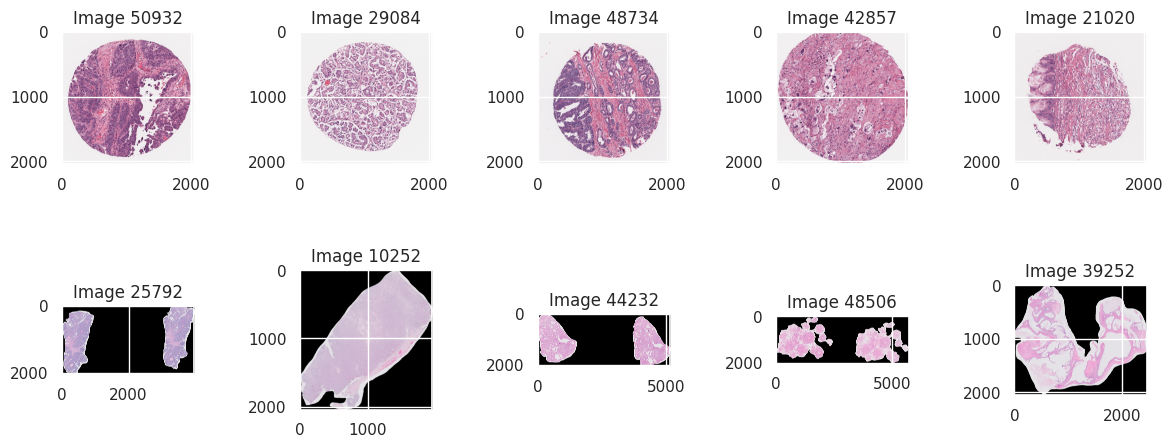

In [129]:
# Plot resized images
plot_images(resized_images)

In [130]:
resized_images_2 = resized_images.copy()

## Eliminate duplicates

In [131]:
# Signal smoothing
def smooth_signal(signal, window_length=5, polyorder=3):
    return savgol_filter(signal, window_length, polyorder)

# Peak detection
def detect_peaks(signal, prominence=150):  # Adjust prominence as needed
    peaks, _ = find_peaks(signal, prominence=prominence)
    return peaks

# Image cropping
def crop_image(image):
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Threshold the image to create a binary image
    _, binary = cv2.threshold(gray, 1, 255, cv2.THRESH_BINARY)

    # Find the contours (regions) in the binary image
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Extract bounding boxes around each contour and save them as individual images
    cropped_images=[]
    for i, contour in enumerate(contours):
        x, y, w, h = cv2.boundingRect(contour)
        cropped_image = image[y:y+h, x:x+w]
        if np.sum(np.array(cropped_image))>100000:
            cropped_images.append(cropped_image)
    return cropped_images

def scale_signal(signal, min_range, max_range):
    # Find the minimum and maximum of the signal
    min_value = np.min(signal)
    max_value = np.max(signal)
    
    # Scale the signal
    scaled_signal = min_range + (signal - min_value) / (max_value - min_value) * (max_range - min_range)
    
    return scaled_signal

In [132]:
# Eliminate duplicates
deduplicated_images = resized_images_2.copy()

In [133]:
for i, img in enumerate(deduplicated_images.values()):
    img_id = list(deduplicated_images.keys())[i]
    img = np.array(img)

    # Check if image is TMA
    image_width_value = train_df.loc[train_df['image_id'] == img_id, 'image_width'].values[0]
    if image_width_value < 4000:
        final_img = img
    else:
        # Smooth signal
        smoothed_signal = smooth_signal(np.mean(img[:,:,0], axis=0))
        # Detect peaks
        peaks = detect_peaks(smoothed_signal)
        height = img.shape[0]
        if len(peaks) > 1:
            images = crop_image(img)
            final_img = images[0]
        else:
            final_img = img

    deduplicated_images[img_id] = final_img

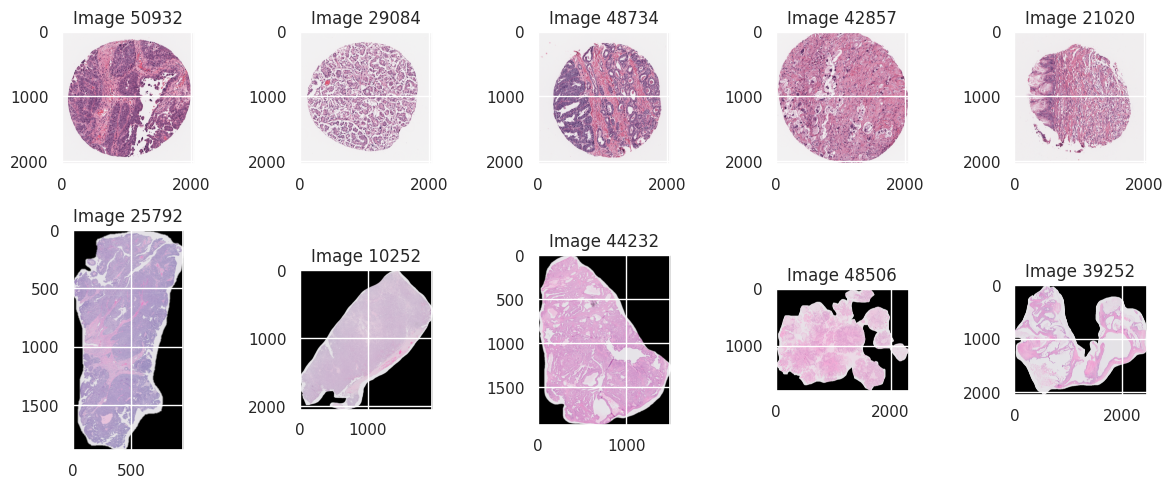

In [134]:
# Plot deduplicated images
plot_images(deduplicated_images)

## Extract tiles

### Hypothetical grids

In [135]:
def display_grid_over_image(image_dict, tile_size_wsi, tile_size_tma):
    
    # Create a figure with two rows and five columns
    fig, axes = plt.subplots(2, 5, figsize=(14, 6))

    # Iterate over the dictionary and plot images
    for i, img in enumerate(image_dict.values()):
        
        img_id = list(image_dict.keys())[i]
        
        # Get the image dimensions
        width, height = img.shape[:2]
        
        row = i // 5
        col = i % 5
        
        # Display the image
        axes[row, col].imshow(img, cmap='gray')
        
        # Check if image is TMA
        image_width_value = train_df.loc[train_df['image_id'] == img_id, 'image_width'].values[0]
        if image_width_value < 4000:
            tile_size = tile_size_tma
            color = 'blue'
        else:
            tile_size = tile_size_wsi
            color = 'green'
        
        # Add grid lines
        for i in range(0, height, tile_size[1]):
            axes[row, col].axvline(i, color=color, linestyle='-', linewidth=0.8)

        for j in range(0, width, tile_size[0]):
            axes[row, col].axhline(j, color=color, linestyle='-', linewidth=0.8)

        # Set title   
        axes[row, col].axis('off')
        axes[row, col].set_title(f'Image {img_id}')
        # Set aspect ratio to 'equal' for a square grid
        axes[row, col].set_aspect('equal', adjustable='box')
    
    # Adjust the spacing between subplots
    plt.subplots_adjust(wspace=0.2, hspace=0.1)

    # Show the figure
    plt.show()

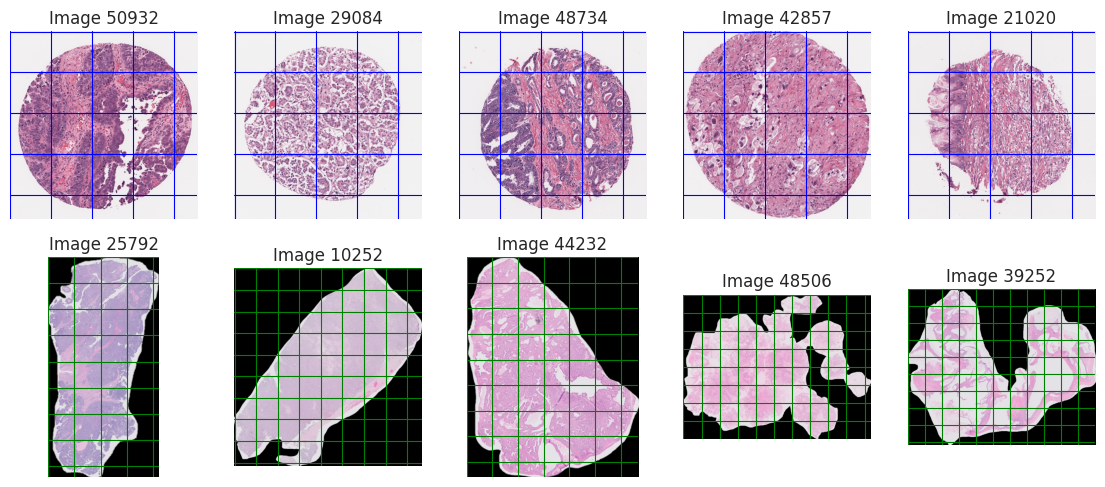

In [136]:
display_grid_over_image(deduplicated_images, (224, 224), (448, 448))

### Actual grid extraction

In [137]:
# Eliminate duplicates
tiles_images = deduplicated_images.copy()

In [138]:
def is_tile_meaningful(tile, threshold, tma):
    threshold_std, threshold_mean = threshold
    if tma:
        # Check if the standard deviation of pixel values is above the threshold
        out = np.std(tile) > threshold_std
    else:
        out = np.mean(tile) > threshold_mean
    return out

def extract_tiles(image, tile_size_wsi, tile_size_tma, threshold, img_id, output_path):
    height, width = image.shape[:2]
    tiles = []
    
    # Check if image is TMA
    image_width_value = train_df.loc[train_df['image_id'] == img_id, 'image_width'].values[0]
    if image_width_value < 4000:
        tile_size = tile_size_tma
        tma = True
    else:
        tile_size = tile_size_wsi
        tma = False

    for y in range(0, height, tile_size):
        for x in range(0, width, tile_size):
            tile = image[y:y+tile_size, x:x+tile_size]
            
            # Check if the tile has meaningful tissue information
            if is_tile_meaningful(tile, threshold, tma):
                tile = cv2.resize(tile, (224, 224))
                tiles.append((x, y, tile))
            

    # Create a folder for the patient
    patient_folder = os.path.join(output_path, f"patient_{img_id}")
    os.makedirs(patient_folder, exist_ok=True)

    # Save each tile as a PNG
    for i, (x, y, tile) in enumerate(tiles):
        tile_image = Image.fromarray(tile)
        tile_image.save(os.path.join(patient_folder, f"tile_{img_id}_{i}_{x}_{y}.png"))

In [147]:
# Set variables
output_path = "/kaggle/working/"
threshold = (30, 20)  # Adjust this threshold
tile_size_wsi = 224
tile_size_tma = 448

print("extracting tiles")

# Call the function
for i, img in enumerate(tiles_images.values()):
    img_id = list(tiles_images.keys())[i]
    extract_tiles(img, tile_size_wsi, tile_size_tma, threshold, img_id, output_path)

extracting tiles


## Visualize tiles

In [140]:
def plot_all_tiles(patient_id, output_path):
    patient_folder = os.path.join(output_path, f"patient_{patient_id}")
    tiles = []

    # Collect tiles and their positions
    for filename in os.listdir(patient_folder):
        if filename.endswith(".png"):
            match = re.match(r"tile_(\d+)_(\d+)_(\d+)_(\d+).png", filename)

            if match:
                index, _, x, y = map(int, match.groups())
                tiles.append((index, x, y, filename))

    # Sort tiles by index
    tiles.sort(key=lambda x: x[0])

    # Determine the size of the composite image
    max_x = max(tile[1] for tile in tiles)
    max_y = max(tile[2] for tile in tiles)
    composite_image = np.ones((max_y + 224, max_x + 224, 3), dtype=np.uint8) * 255  # White background

    # Paste each tile into the composite image
    for _, x, y, filename in tiles:
        tile_image = cv2.imread(os.path.join(patient_folder, filename))
        composite_image[y:y+224, x:x+224, :] = tile_image

    # Display the composite image
    plt.imshow(composite_image)
    plt.title(f"Patient {patient_id} - Composite Image")
    plt.axis("off")
    plt.show()


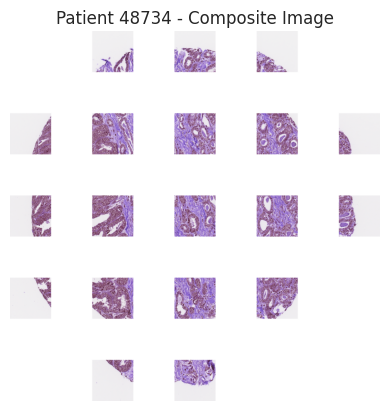

In [141]:
patient_id = 48734
output_path = "/kaggle/working/"

plot_all_tiles(patient_id, output_path)

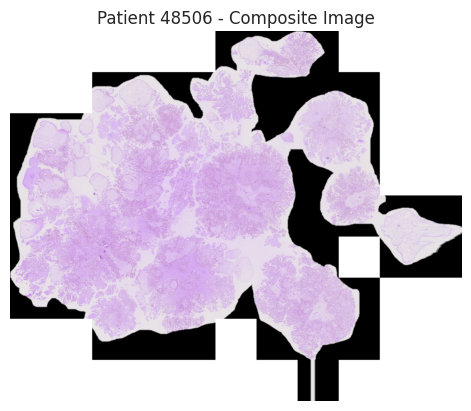

In [142]:
patient_id = 48506
output_path = "/kaggle/working/"

plot_all_tiles(patient_id, output_path)

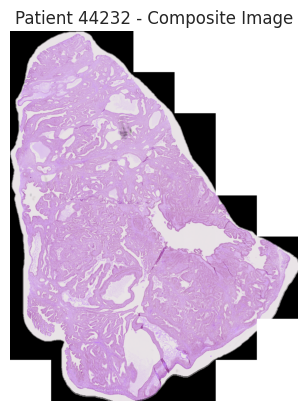

In [143]:
patient_id = 44232
output_path = "/kaggle/working/"

plot_all_tiles(patient_id, output_path)